# Load data

In [1]:
import requests

base_url = "https://github.com/DataTalksClub/llm-zoomcamp/blob/main"
relative_url = "03-vector-search/eval/documents-with-ids.json"
docs_url = f"{base_url}/{relative_url}?raw=1"
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [2]:
import pandas as pd

base_url = "https://github.com/DataTalksClub/llm-zoomcamp/blob/main"
relative_url = "03-vector-search/eval/ground-truth-data.csv"
ground_truth_url = f"{base_url}/{relative_url}?raw=1"

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == "machine-learning-zoomcamp"]
ground_truth = df_ground_truth.to_dict(orient="records")

In [4]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [3]:
doc_idx = {d["id"]: d for d in documents}

# Elastic Search

In [5]:
from elasticsearch import Elasticsearch

In [6]:
es_client = Elasticsearch("http://localhost:9200")

## Create index

In [8]:
index_settings = {
    "settings": {"number_of_shards": 1, "number_of_replicas": 0},
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine",
            },
        }
    },
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

# Prepare Open AI client object

In [9]:
from openai import OpenAI

In [10]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [11]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [12]:
client

# Create Vector Embeddings

In [13]:
from sentence_transformers import SentenceTransformer

In [14]:
model = SentenceTransformer("multi-qa-MiniLM-L6-cos-v1")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Encode documents to vectors and data to index

In [15]:
from tqdm.auto import tqdm

In [17]:
for doc in tqdm(documents):

    qt = doc["question"] + " " + doc["text"]
    doc["question_text_vector"] = model.encode(qt)

    es_client.index(index=index_name, document=doc)

  0%|          | 0/948 [00:00<?, ?it/s]

# Prepare Embedding Retrieval

In [18]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {"term": {"course": course}},
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"],
    }

    es_results = es_client.search(index=index_name, body=search_query)

    result_docs = []

    for hit in es_results["hits"]["hits"]:
        result_docs.append(hit["_source"])

    return result_docs

In [19]:
def question_text_vector_knn(q):
    answer = q["question"]
    course = q["course"]

    v_q = model.encode(answer)

    return elastic_search_knn("question_text_vector", v_q, course)

In [20]:
question = "I just discovered the course. Can I still join it?"

In [21]:
question_text_vector_knn(
    dict(
        question="Are sessions recorded if I miss one?",
        course="machine-learning-zoomcamp",
    )
)

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

# RAG flow

In [22]:
def build_prompt(query, search_results):
    prompt_template = """
    You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
    Use only the facts from the CONTEXT when answering the QUESTION.

    QUESTION: {question}

    CONTEXT: 
    {context}
    """.strip()

    context = ""

    for doc in search_results:
        context = (
            context
            + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
        )

    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [23]:
def llm(prompt, model="gpt-4o"):
    response = client.chat.completions.create(
        model=model, messages=[{"role": "user", "content": prompt}]
    )

    return response.choices[0].message.content

In [24]:
def rag(query: dict, model="gpt-4o") -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query["question"], search_results)
    answer = llm(prompt, model=model)
    return answer

#### Question

In [25]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

#### Answer from RAG system

In [27]:
rag(ground_truth[10])

'Yes, sessions are recorded if you miss one. You can catch up on any missed content through the recordings and ask your questions for office hours in advance. These will be covered during the live stream, and you can also ask questions in Slack.'

#### Original Answer

In [28]:
doc_idx["5170565b"]["text"]

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

# Offline Evaluation

## Generate answers from GPTs

Simple example before automatization

In [29]:
original_answer = "Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack."
llm_answer = "Yes, sessions are recorded. If you miss a session, you won’t miss anything because everything is recorded. You can also ask your questions for office hours in advance, and they will be covered during the live stream. Additionally, you can always ask questions in Slack."

In [30]:
vector_llm = model.encode(llm_answer)
vector_original = model.encode(original_answer)

In [31]:
cos_similarity = vector_llm.dot(vector_original)

In [32]:
cos_similarity

0.79916126

Application on the whole dataset

In [33]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [ ]:
answers = {}

#### Stopped mid way through to prevent spending unecessary costs

In [38]:
for i, rec in enumerate(tqdm(ground_truth)):

    if i in answers:
        continue

    # get original answer
    doc_id = rec["document"]
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc["text"]

    # get llm answer
    answer_llm = rag(rec)

    answers[i] = {
        "answer_llm": answer_llm,
        "answer_orig": answer_orig,
        "document": doc_id,
        "question": rec["question"],
        "course": rec["course"],
    }

  0%|          | 0/1830 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [39]:
results_gpt4o = [None] * len(ground_truth)

for i, val in answers.items():
    results_gpt4o[i] = val.copy()
    results_gpt4o[i].update(ground_truth[i])

### Test with code paralelization

In [81]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)


def map_progress(pool, seq, f):
    # seq: input data to the function that will run in paralell
    # f: function to run
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [85]:
def process_record_35(rec):
    model = "gpt-3.5-turbo"
    answer_llm = rag(rec, model=model)

    doc_id = rec["document"]
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc["text"]

    return {
        "answer_llm": answer_llm,
        "answer_orig": answer_orig,
        "document": doc_id,
        "question": rec["question"],
        "course": rec["course"],
    }

In [86]:
process_record_35(ground_truth[10])

{'answer_llm': "Yes, if you miss a session, everything is recorded so you won't miss anything.",
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [87]:
results_gpt35 = map_progress(pool, ground_truth, process_record_35)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [88]:
df_gpt35 = pd.DataFrame(results_gpt35)
df_gpt35.head(3)

,answer_llm,answer_orig,document,question,course
0,You can sign up for the course by going to the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,"I'm sorry, but based on the context provided, ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp


#### Read already processed data from github 

In [43]:
import pandas as pd

In [47]:
df_gpt35 = pd.read_csv("data/results-gpt35.csv")

In [ ]:
df_gpt4o = pd.read_csv("data/results-gpt4o.csv")

In [73]:
df_gpt40_mini = pd.read_csv("data/results-gpt4o-mini.csv")

## Cosine similarity evaluation

RAG Evaluation Flow

A --> Q --> A'

We have an original question + answer.

From the original answer, we can formulate new questions, creating a ground truth dataset of questions.

This ground truth dataset can be used in multiple things:
- We can use these questions to evaluate the quality of the context retrieval: for each GT question, the search method should be able to retrieve the original question+answer pair that was used to generate it.
- We can also evaluate the quality of our LLM by generating new answers from the generated GT questions. Then, we can compare the original answers with the generated ones.

In [49]:
results_gpt4o = df_gpt4o.to_dict(orient="records")

In [50]:
results_gpt35 = df_gpt35.to_dict(orient="records")

In [74]:
results_gpt40_mini = df_gpt40_mini.to_dict(orient="records")

In [51]:
def compute_similarity(record):

    answer_orig = record["answer_orig"]
    answer_llm = record["answer_llm"]

    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)

    return v_llm.dot(v_orig)

### GPT4o

In [52]:
similarity = []

for record in tqdm(results_gpt4o):

    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [53]:
df_gpt4o["cosine"] = similarity

In [60]:
df_gpt4o["cosine"].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153426
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

### GPT3.5

In [69]:
similarity = []

for record in tqdm(results_gpt35):

    sim = compute_similarity(record)
    similarity.append(sim)

df_gpt35["cosine"] = similarity
df_gpt35["cosine"].describe()

  0%|          | 0/1830 [00:00<?, ?it/s]

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714784
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

### GPT4.0 Mini

In [75]:
similarity = []

for record in tqdm(results_gpt40_mini):

    sim = compute_similarity(record)
    similarity.append(sim)

df_gpt40_mini["cosine"] = similarity
df_gpt40_mini["cosine"].describe()

  0%|          | 0/1830 [00:00<?, ?it/s]

count    1830.000000
mean        0.680332
std         0.215962
min        -0.141910
25%         0.585866
50%         0.733998
75%         0.836750
max         0.982701
Name: cosine, dtype: float64

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_29520/313992817.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='4o')
/tmp/ipykernel_29520/313992817.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35['cosine'], label='3.5')
/tmp/ipykernel_29520/313992817.py:3: UserWarning: 

`distplot` is

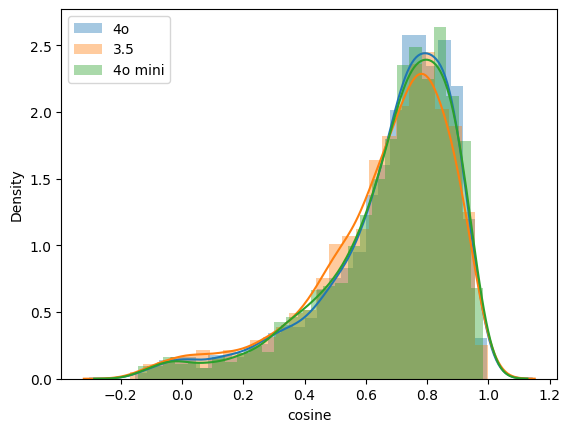

In [76]:
sns.distplot(df_gpt4o["cosine"], label="4o")
sns.distplot(df_gpt35["cosine"], label="3.5")
sns.distplot(df_gpt40_mini["cosine"], label="4o mini")
plt.legend()

## LLM as a judge

In [91]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [89]:
df_sample = df_gpt40_mini.sample(150, random_state=1)

In [92]:
samples = df_sample.to_dict(orient="records")

In [93]:
record = samples[0]
record

{'answer_llm': 'The syntax for using `precision_recall_fscore_support` in Python is as follows:\n\n```python\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n```',
 'answer_orig': 'Scikit-learn offers another way: precision_recall_fscore_support\nExample:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.9010756015777588}

In [94]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_

In [95]:
answer = llm(prompt, model="gpt-4o-mini")
answer

'{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer provides the correct syntax for using the `precision_recall_fscore_support` function in Python, which directly addresses the generated question and matches the information given in the original answer."\n}'

### Evaluate RAG using original answer, generated question and generated answer (A->Q->A)

In [96]:
import json

In [97]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model="gpt-4o-mini")
    evaluations.append(evaluation)

  0%|          | 0/150 [00:00<?, ?it/s]

In [98]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [99]:
df_evaluations = pd.DataFrame(json_evaluations)

In [100]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           125
PARTLY_RELEVANT     16
NON_RELEVANT         9
Name: count, dtype: int64

### Evaluate RAG using only question and generated answer (Q->A)

In [102]:
evaluations_2 = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model="gpt-4o-mini")
    evaluations_2.append(evaluation)

  0%|          | 0/150 [00:00<?, ?it/s]

In [103]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [104]:
df_evaluations_2.Relevance.value_counts()

Relevance
RELEVANT           130
PARTLY_RELEVANT     17
NON_RELEVANT         3
Name: count, dtype: int64

In [105]:
df_evaluations.to_csv("data/evaluations-aqa.csv", index=False)
df_evaluations_2.to_csv("data/evaluations-qa.csv", index=False)

# Homework

In [4]:
import requests
import pandas as pd

base_url = "https://github.com/DataTalksClub/llm-zoomcamp/blob/main"
relative_url = "04-monitoring/data/results-gpt4o-mini.csv"
docs_url = f"{base_url}/{relative_url}?raw=1"
df = pd.read_csv(docs_url)

In [5]:
df = df.iloc[:300]

## Q1. Getting the embeddings model

In [6]:
from sentence_transformers import SentenceTransformer

model_name = "multi-qa-mpnet-base-dot-v1"
embedding_model = SentenceTransformer(model_name)

/Users/marialoureiro/Documents/GitHub/virtualenvs/llm_zoomcamp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You try to use a model that was created with version 3.0.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.



/Users/marialoureiro/Documents/GitHub/virtualenvs/llm_zoomcamp/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
answer_llm = df.iloc[0].answer_llm

In [8]:
answer_llm

'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).'

In [9]:
embedding_model.encode(answer_llm)

array([-4.22446817e-01, -2.24855721e-01, -3.24058682e-01, -2.84758925e-01,
        7.25703500e-03,  1.01186760e-01,  1.03716701e-01, -1.89983398e-01,
       -2.80598793e-02,  2.71588564e-01, -1.15336932e-01,  1.14666238e-01,
       -8.49586725e-02,  3.32365185e-01,  5.52721620e-02, -2.22195536e-01,
       -1.42541021e-01,  1.02519184e-01, -1.52333528e-01, -2.02912644e-01,
        1.98424309e-02,  8.38151574e-02, -5.68631887e-01,  2.32842490e-02,
       -1.67292863e-01, -2.39256561e-01, -8.05462673e-02,  2.57084072e-02,
       -8.15464333e-02, -7.39288852e-02, -2.61549741e-01,  1.92575566e-02,
        3.22909147e-01,  1.90357029e-01, -9.34726413e-05, -2.13165477e-01,
        2.88943425e-02, -1.79527458e-02, -5.92762120e-02,  1.99918240e-01,
       -4.75171879e-02,  1.71633974e-01, -2.45915111e-02, -9.38058943e-02,
       -3.57002556e-01,  1.33263677e-01,  1.94046140e-01, -1.18530810e-01,
        4.56915319e-01,  1.47728160e-01,  3.35945100e-01, -1.86959893e-01,
        2.45954469e-01, -

Answer: -0.42

## Q2. Computing the dot product

In [10]:
df.iloc[0]

answer_llm     You can sign up for the course by visiting the...
answer_orig    Machine Learning Zoomcamp FAQ\nThe purpose of ...
document                                                0227b872
question                     Where can I sign up for the course?
course                                 machine-learning-zoomcamp
Name: 0, dtype: object

In [12]:
evaluations = []

for index, row in df.iterrows():

    evaluations.append(
        embedding_model.encode(row.answer_llm).dot(
            embedding_model.encode(row.answer_orig)
        )
    )

In [13]:
import numpy as np

# Compute the 25th, 50th, and 75th percentiles
percentiles = np.percentile(evaluations, [25, 50, 75])

print(f"25th Percentile: {percentiles[0]}")
print(f"50th Percentile (Median): {percentiles[1]}")
print(f"75th Percentile: {percentiles[2]}")

25th Percentile: 24.307842254638672
50th Percentile (Median): 28.33685874938965
75th Percentile: 31.674304962158203


Answer: 31.67

## Q3. Computing the cosine

In [14]:
def vector_normalization(v):
    norm = np.sqrt((v * v).sum())
    v_norm = v / norm

    return v_norm

In [15]:
evaluations_norm = []

for index, row in df.iterrows():

    answer_llm_norm = vector_normalization(embedding_model.encode(row.answer_llm))
    answer_orig_norm = vector_normalization(embedding_model.encode(row.answer_orig))

    evaluations_norm.append(answer_llm_norm.dot(answer_orig_norm))

In [16]:
import numpy as np

# Compute the 25th, 50th, and 75th percentiles
percentiles = np.percentile(evaluations_norm, [25, 50, 75])

print(f"25th Percentile: {percentiles[0]}")
print(f"50th Percentile (Median): {percentiles[1]}")
print(f"75th Percentile: {percentiles[2]}")

25th Percentile: 0.6512733697891235
50th Percentile (Median): 0.763760894536972
75th Percentile: 0.8362347185611725


Answer: 0.83

## Q4. Rouge

In [17]:
!pip install rouge

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [18]:
df.iloc[10]

answer_llm     Yes, all sessions are recorded, so if you miss...
answer_orig    Everything is recorded, so you won’t miss anyt...
document                                                5170565b
question                    Are sessions recorded if I miss one?
course                                 machine-learning-zoomcamp
Name: 10, dtype: object

In [27]:
from rouge import Rouge

rouge_scorer = Rouge()

test_pair = df.iloc[10]

scores = rouge_scorer.get_scores(test_pair["answer_llm"], test_pair["answer_orig"])[0]

In [26]:
scores

{'rouge-1': {'r': 0.45454545454545453,
  'p': 0.45454545454545453,
  'f': 0.45454544954545456},
 'rouge-2': {'r': 0.21621621621621623,
  'p': 0.21621621621621623,
  'f': 0.21621621121621637},
 'rouge-l': {'r': 0.3939393939393939,
  'p': 0.3939393939393939,
  'f': 0.393939388939394}}

Answer: 0.45

## Q5. Average rouge score

In [22]:
np.mean([scores["rouge-1"]["f"], scores["rouge-2"]["f"], scores["rouge-l"]["f"]])

0.35490034990035496

Answer: 0.35

In [24]:
pd.DataFrame.from_dict(scores)

,rouge-1,rouge-2,rouge-l
r,0.454545,0.216216,0.393939
p,0.454545,0.216216,0.393939
f,0.454545,0.216216,0.393939


## Q6. Average rouge score for all the data points

In [ ]:
import pandas as pd

# Sample evaluations data for demonstration purposes
# Replace this list with your loop where each evaluation produces a similar dictionary
evaluations = [
    {
        "rouge-1": {
            "r": 0.45454545454545453,
            "p": 0.45454545454545453,
            "f": 0.45454544954545456,
        },
        "rouge-2": {
            "r": 0.21621621621621623,
            "p": 0.21621621621621623,
            "f": 0.21621621121621637,
        },
        "rouge-l": {
            "r": 0.3939393939393939,
            "p": 0.3939393939393939,
            "f": 0.393939388939394,
        },
    },
    {
        "rouge-1": {"r": 0.5, "p": 0.5, "f": 0.5},
        "rouge-2": {"r": 0.25, "p": 0.25, "f": 0.25},
        "rouge-l": {"r": 0.4, "p": 0.4, "f": 0.4},
    },
    # Add more evaluations here
]

# List to store each evaluation's flattened dictionary
flattened_results = []

# Flatten each evaluation dictionary
for evaluation in evaluations:
    # Flatten the dictionary for a single evaluation
    flat_dict = {
        "rouge-1_r": evaluation["rouge-1"]["r"],
        "rouge-1_p": evaluation["rouge-1"]["p"],
        "rouge-1_f": evaluation["rouge-1"]["f"],
        "rouge-2_r": evaluation["rouge-2"]["r"],
        "rouge-2_p": evaluation["rouge-2"]["p"],
        "rouge-2_f": evaluation["rouge-2"]["f"],
        "rouge-l_r": evaluation["rouge-l"]["r"],
        "rouge-l_p": evaluation["rouge-l"]["p"],
        "rouge-l_f": evaluation["rouge-l"]["f"],
    }

    # Append the flattened dictionary to the list
    flattened_results.append(flat_dict)

In [29]:
evaluations_rouge = []

rouge_scorer = Rouge()

for index, row in df.iterrows():

    scores = rouge_scorer.get_scores(row["answer_llm"], row["answer_orig"])[0]

    flat_dict = {
        "rouge-1_r": scores["rouge-1"]["r"],
        "rouge-1_p": scores["rouge-1"]["p"],
        "rouge-1_f": scores["rouge-1"]["f"],
        "rouge-2_r": scores["rouge-2"]["r"],
        "rouge-2_p": scores["rouge-2"]["p"],
        "rouge-2_f": scores["rouge-2"]["f"],
        "rouge-l_r": scores["rouge-l"]["r"],
        "rouge-l_p": scores["rouge-l"]["p"],
        "rouge-l_f": scores["rouge-l"]["f"],
    }

    evaluations_rouge.append(flat_dict)

In [31]:
# Convert the list of flattened dictionaries to a DataFrame
df = pd.DataFrame(evaluations_rouge)

In [32]:
df.head()

,rouge-1_r,rouge-1_p,rouge-1_f,rouge-2_r,rouge-2_p,rouge-2_f,rouge-l_r,rouge-l_p,rouge-l_f
0,0.061224,0.214286,0.095238,0.017544,0.071429,0.028169,0.061224,0.214286,0.095238
1,0.081633,0.266667,0.125000,0.035088,0.133333,0.055556,0.061224,0.200000,0.093750
2,0.326531,0.571429,0.415584,0.140351,0.242424,0.177778,0.306122,0.535714,0.389610
3,0.163265,0.320000,0.216216,0.035088,0.071429,0.047059,0.142857,0.280000,0.189189
4,0.265306,0.097015,0.142076,0.070175,0.022346,0.033898,0.224490,0.082090,0.120219


In [34]:
df.mean()

rouge-1_r    0.357817
rouge-1_p    0.472618
rouge-1_f    0.378844
rouge-2_r    0.198613
rouge-2_p    0.258626
rouge-2_f    0.206965
rouge-l_r    0.334597
rouge-l_p    0.440623
rouge-l_f    0.353807
dtype: float64

Answer: 0.20